In [1]:
# Implementação do classificador naive bayes a fim de treinar um modelo de machine learning
# A base de dados, assim como o exemplo, também foi disponibilizada durante o curso de Data Science (Fernando Amaral e Jones Granatyr)
# A base de dados descreve solicitação de crédito de clientes de um banco alemão, verificando como classe se eles são bons ou maus pagadores

In [2]:
# Import das bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from yellowbrick.classifier import ConfusionMatrix 

In [59]:
# Carrega a base de dados e logo em seguida exibe o formato da mesma
base = pd.read_csv('Credit.csv')
base.shape

(1000, 21)

In [60]:
# Breve visualização da base de dados
base

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,'no checking',12,'existing paid',furniture/equipment,1736,<100,4<=X<7,3,'female div/dep/mar',none,...,'real estate',31,none,own,1,'unskilled resident',1,none,yes,good
996,<0,30,'existing paid','used car',3857,<100,1<=X<4,4,'male div/sep',none,...,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
997,'no checking',12,'existing paid',radio/tv,804,<100,>=7,4,'male single',none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,'existing paid',radio/tv,1845,<100,1<=X<4,4,'male single',none,...,'no known property',23,none,'for free',1,skilled,1,yes,yes,bad


In [61]:
# Verifica se há a presença de valores nulos
base.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

In [62]:
# Verifica o tipo de dados de cada coluna. Sendo possível verificar que há muitas que não são do tipo numérico
base.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [63]:
# Detalhamento das colunas numéricas utilizando describe
base.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [64]:
# Separa em variáveis os previsores e a classe

previsores = base.iloc[:,0:20] # Uso do iloc para armazenar da coluna 0 a 19
classe = base['class'].values

In [65]:
# Transformação dos atributos categóricos em atributos numéricos, utilizando LabelEncoder
# Armazena em uma lista todos os encoders que serão utilizados em cada atributo. Armazena para uso posterior
lista_encoder = []

# Percorre todas as colunas
for coluna in previsores.columns:
    # Caso o atributo não seja numérico, é transformado em numérico
    if not pd.api.types.is_numeric_dtype(previsores[coluna]):
        lb = LabelEncoder()
        previsores[coluna] = lb.fit_transform(previsores[coluna])
        lista_encoder.append(lb)

In [66]:
previsores

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,2,6,1,7,1169,0,3,4,3,2,4,2,67,1,1,2,3,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,2,2,22,1,1,1,3,1,0,1
2,0,12,1,4,2096,3,1,2,3,2,3,2,49,1,1,1,2,2,0,1
3,2,42,3,5,7882,3,1,2,3,1,4,0,45,1,0,1,3,2,0,1
4,2,24,2,1,4870,3,0,3,3,2,4,1,53,1,0,2,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,12,3,5,1736,3,1,3,0,2,4,2,31,1,1,1,2,1,0,1
996,2,30,3,2,3857,3,0,4,1,2,4,0,40,1,1,1,0,1,1,1
997,0,12,3,7,804,3,3,4,3,2,4,3,38,1,1,1,3,1,0,1
998,2,45,3,7,1845,3,0,4,3,2,4,1,23,1,0,1,3,1,1,1


In [67]:
previsores = previsores.values

In [68]:
# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
# A divisão (hold out) melhora a avaliação de performance
x_treino, x_teste, y_treino, y_teste = train_test_split(previsores,
                                                                  classe,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

In [69]:
# Criação do modelo
naive_bayes = GaussianNB()
# Treinamento do modelo
naive_bayes.fit(x_treino, y_treino)

GaussianNB()

In [70]:
# Previsões feitas a partir dos  registros de teste
previsoes = naive_bayes.predict(x_teste)
previsoes

array(['bad', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'bad', 'bad', 'bad', 'good', 'bad', 'good', 'good', 'good',
       'good', 'bad', 'good', 'bad', 'good', 'bad', 'good', 'good', 'bad',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'good',
       'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'good', 'good', 'bad', 'bad', 'good', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'bad',
       'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good',
      

In [71]:
# Geração da matriz de confusão (verificando a taxa de acerto e erro)
matriz_confussao = confusion_matrix(y_teste, previsoes)
matriz_confussao 

array([[ 41,  45],
       [ 42, 172]], dtype=int64)

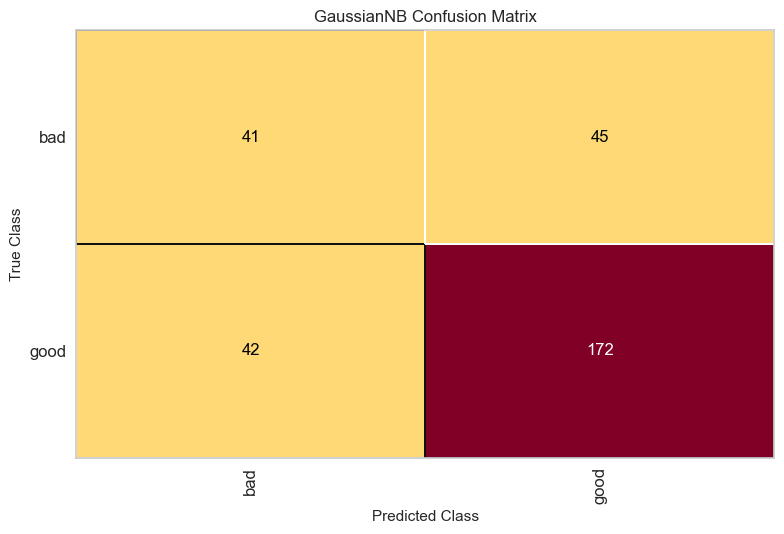

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [72]:
# Geração de uma melhor visualização da matriz de confussao
m_c = ConfusionMatrix(GaussianNB())
m_c.fit(x_treino, y_treino)
m_c.score(x_teste, y_teste)
m_c.poof()

In [73]:
# Cálculo da taxa de acerto e erro do modelo treinado
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
taxa_acerto

0.71

In [74]:
# Coleta de novos dados para serem feitas as previsões
base_nova = pd.read_csv('NovoCredit.csv')
base_nova.shape

(1, 20)

In [75]:
base_nova

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,'no checking',12,'existing paid',radio/tv,804,<100,>=7,4,'male single',none,4,car,38,none,own,1,skilled,1,none,yes


In [76]:
x_base_nova = base_nova.iloc[:,0:20]

In [77]:
# Criação de uma variável auxiliar para utilizar os encoders antes armazenados
pos = 0
# Percorre todas as colunas
for coluna in x_base_nova.columns:
    # Caso o atributo não seja numérico, é transformado em numérico
    if not pd.api.types.is_numeric_dtype(x_base_nova[coluna]):
        # Utiliza o encoder antes utilizado para cada atributo
        x_base_nova[coluna] = lista_encoder[pos].transform(x_base_nova[coluna])
        pos = pos + 1

In [80]:
x_base_nova = x_base_nova.values

In [81]:
# Resultado da previsão
naive_bayes.predict(x_base_nova)

array(['good'], dtype='<U4')